In [ ]:
!pip install datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 5.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_

Epoch 1	Training Loss: 0.4933	Validation Loss: 0.2952	Accuracy: 0.010101	Precision: 1.000000	Recall: 0.009479	F1 Score: 0.018779
Epoch 2	Training Loss: 0.3113	Validation Loss: 0.2796	Accuracy: 0.030303	Precision: 0.666667	Recall: 0.028436	F1 Score: 0.054545
Epoch 3	Training Loss: 0.2883	Validation Loss: 0.2584	Accuracy: 0.090909	Precision: 0.750000	Recall: 0.099526	F1 Score: 0.175732
Epoch 4	Training Loss: 0.2718	Validation Loss: 0.2540	Accuracy: 0.156566	Precision: 0.702128	Recall: 0.156398	F1 Score: 0.255814
Epoch 5	Training Loss: 0.2553	Validation Loss: 0.2405	Accuracy: 0.176768	Precision: 0.847826	Recall: 0.184834	F1 Score: 0.303502
Epoch 6	Training Loss: 0.2322	Validation Loss: 0.2275	Accuracy: 0.297980	Precision: 0.761905	Recall: 0.303318	F1 Score: 0.433898
Epoch 7	Training Loss: 0.2093	Validation Loss: 0.2060	Accuracy: 0.343434	Precision: 0.886076	Recall: 0.331754	F1 Score: 0.482759
Epoch 8	Training Loss: 0.2019	Validation Loss: 0.2019	Accuracy: 0.398990	Precision: 0.833333	Reca

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


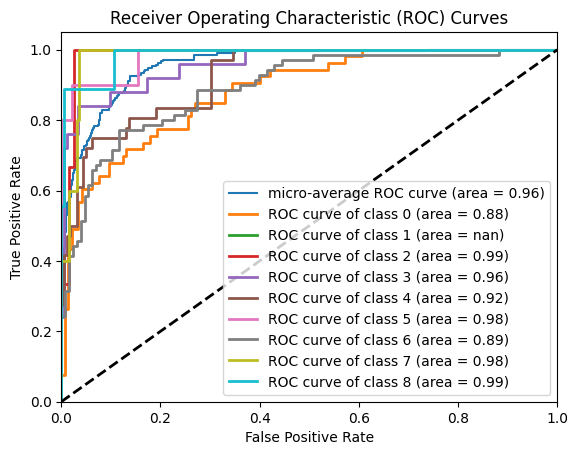

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
from torchaudio.transforms import MelSpectrogram

class LungSoundDataset(Dataset):
    def __init__(self, audio_files, labels, transform=None):
        self.audio_files = audio_files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_file = self.audio_files[idx]
        label = self.labels[idx]
        waveform, sample_rate = torchaudio.load(audio_file)

        if self.transform:
            spectrogram = self.transform(waveform)
        else:
            spectrogram = waveform

        return spectrogram, torch.tensor(label, dtype=torch.float)

# Hastalık etiketlerini çıkarma
def extract_disease_labels(filename):
    underscore_index = filename.find('_')
    comma_index = filename.find(',')
    if underscore_index != -1 and comma_index != -1:
        filename_part = filename[underscore_index + 1:comma_index]
    else:
        filename_part = filename
    labels = [label.strip().lower() for label in filename_part.split(' + ')]
    return labels

# Mel-spektrogram Dönüşümü
transform = MelSpectrogram(
    sample_rate=16000,
    n_mels=128,
    hop_length=512
)

# Veri Kümesi Oluşturma
from glob import glob
from sklearn.preprocessing import MultiLabelBinarizer

audio_files = glob('/*.wav') # Dosya yolu
labels_list = [extract_disease_labels(file) for file in audio_files]

mlb = MultiLabelBinarizer()
binary_labels = mlb.fit_transform(labels_list)

X_train, X_val, y_train, y_val = train_test_split(audio_files, binary_labels, test_size=0.2, random_state=42)

train_dataset = LungSoundDataset(X_train, y_train, transform=transform)
val_dataset = LungSoundDataset(X_val, y_val, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Model Tanımı
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 10, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 10)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

num_classes = len(mlb.classes_)
model = CNNModel(num_classes)

# Eğitim
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.sigmoid(outputs).numpy()
            y_true.extend(labels.numpy())
            y_pred.extend(preds)

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = accuracy_score(y_true, y_pred.round())
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred.round(), average='micro')

    print(f"Epoch {epoch+1}\tTraining Loss: {train_loss:.4f}\tValidation Loss: {val_loss:.4f}\tAccuracy: {accuracy:.6f}\tPrecision: {precision:.6f}\tRecall: {recall:.6f}\tF1 Score: {f1:.6f}")

# ROC Curve Plotting
def plot_roc_curves(y_true, y_pred, n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curves for the final evaluation
plot_roc_curves(y_true, y_pred, num_classes)

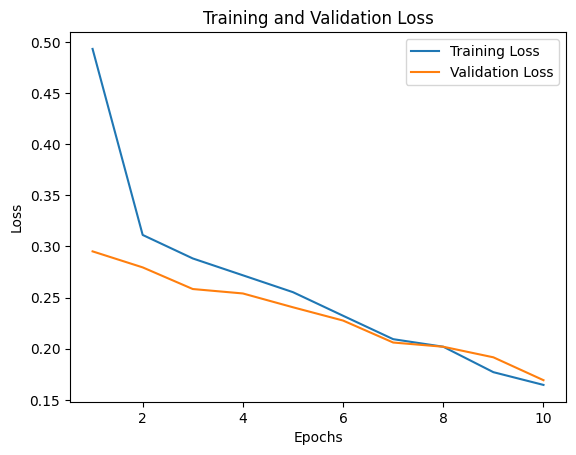

In [ ]:
# Plot training and validation loss
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()